In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-p_321xxe
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-p_321xxe
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 39.3 MB/s eta 0:00:00


In [4]:
!pip install ftfy regex tqdm

In [5]:
!pip install --upgrade --force-reinstall torch torchvision torchaudio

  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
import pytorch_lightning as pl
import numpy as np
import os


In [2]:
# ------------------ 1. Load CIFAR-10 Dataset ------------------
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

labels = train_dataset.classes  # CIFAR-10 class labels


100%|██████████| 170M/170M [00:03<00:00, 48.5MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
# ------------------ 2. Tokenization using CLIP ------------------
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

text_inputs = processor(text=labels, return_tensors="pt", padding=True)

with torch.no_grad():
    text_features = clip_model.get_text_features(**text_inputs)

text_embeddings = text_features.cpu().numpy()  # Not used in training here, but ready for downstream tasks


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [4]:
# ------------------ 3. PyTorch Lightning Model ------------------
class FineTuneModel(pl.LightningModule):
    def __init__(self, num_classes=10):
        super(FineTuneModel, self).__init__()
        self.save_hyperparameters()

        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        self.criterion = nn.CrossEntropyLoss()

        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def forward(self, x):
        return self.model(x)

    def extract_features(self, x):
      # Extract features before the final classification layer
      for name, module in self.model._modules.items():
        x = module(x)
        if name == "10":  # Linear(512, num_classes) is at index 11
            break
      return x

    def training_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.criterion(logits, y)
      acc = (logits.argmax(dim=1) == y).float().mean()

      self.train_losses.append(loss.item())
      self.train_accuracies.append(acc.item())

      self.log("train_loss", loss, prog_bar=True)
      self.log("train_acc", acc, prog_bar=True)

      return loss


    def validation_step(self, batch, batch_idx):
      x, y = batch
      logits = self(x)
      loss = self.criterion(logits, y)
      acc = (logits.argmax(dim=1) == y).float().mean()

      self.val_losses.append(loss.item())
      self.val_accuracies.append(acc.item())

      self.log("val_loss", loss, prog_bar=True)  # ✅ Required for early stopping
      self.log("val_acc", acc, prog_bar=True)


    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}


In [5]:
# ------------------ 4. Train Model with EarlyStopping ------------------
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

device = "cuda" if torch.cuda.is_available() else "cpu"

early_stop = EarlyStopping(monitor="val_loss", patience=3, mode="min")
checkpoint = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

model = FineTuneModel()

trainer = pl.Trainer(
    max_epochs=20,
    accelerator=device,
    log_every_n_steps=10,
    callbacks=[early_stop, checkpoint]
)

trainer.fit(model, train_loader, test_loader)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | Sequential       | 8.8 M  | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
8.8 M     Trainable params
0         Non-trainable params
8.8 M     Total params
35.064    Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

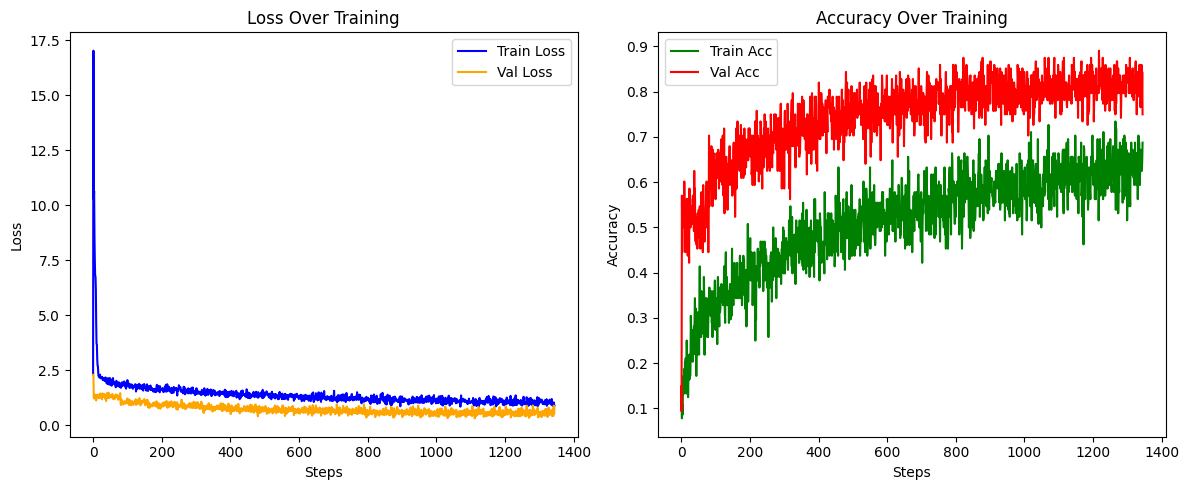

In [7]:
# ------------------ 5. Plot Accuracy and Loss ------------------
import matplotlib.pyplot as plt
def plot_metrics(model):
    # Use the shorter length for steps
    steps = list(range(min(len(model.train_losses), len(model.val_losses))))  # Changed line
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(steps, model.train_losses[:len(steps)], label='Train Loss', color='blue')  # Changed line
    plt.plot(steps, model.val_losses[:len(steps)], label='Val Loss', color='orange')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Loss Over Training')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(steps, model.train_accuracies[:len(steps)], label='Train Acc', color='green')  # Changed line
    plt.plot(steps, model.val_accuracies[:len(steps)], label='Val Acc', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Over Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(model)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



Test Accuracy: 82.02%
              precision    recall  f1-score   support

    airplane       0.81      0.86      0.83      1000
  automobile       0.92      0.90      0.91      1000
        bird       0.75      0.74      0.74      1000
         cat       0.67      0.62      0.64      1000
        deer       0.79      0.82      0.80      1000
         dog       0.73      0.72      0.72      1000
        frog       0.86      0.88      0.87      1000
       horse       0.87      0.85      0.86      1000
        ship       0.90      0.92      0.91      1000
       truck       0.89      0.90      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000


📉 Confusion Matrix:


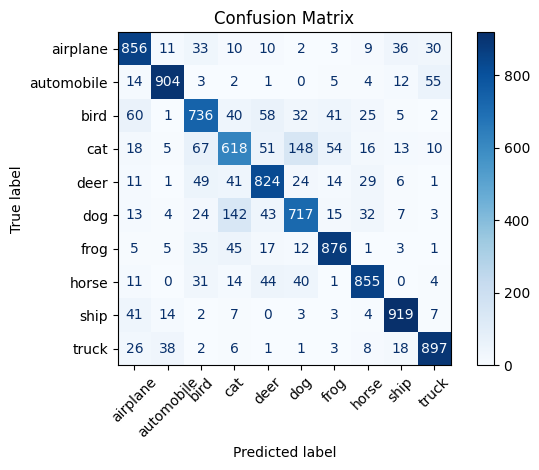

In [13]:
# ------------------ 6. Evaluate on Test Set ------------------
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
def evaluate_model(model, test_loader, device="cuda"):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\nTest Accuracy: {100 * correct / total:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

evaluate_model(model, test_loader, device=device)

📦 Extracting features...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


📉 Running t-SNE...
🎨 Plotting...


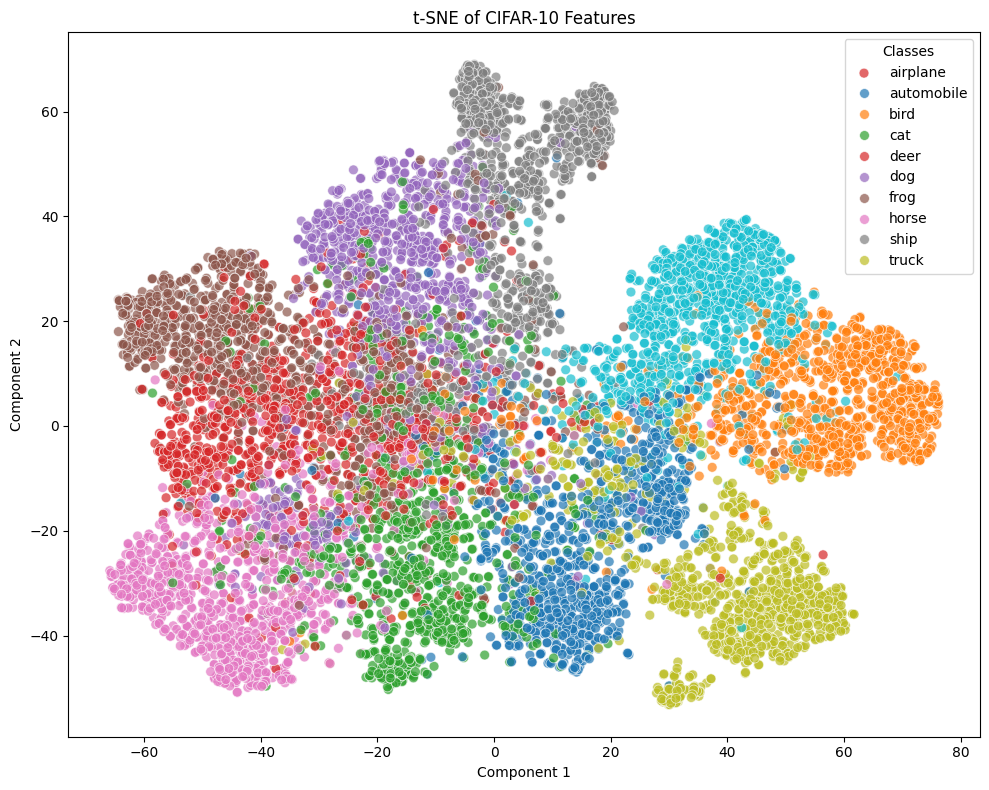

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns

def extract_features(model, dataloader, device):
    model.to(device)
    model.eval()

    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)

            # Forward pass through all layers except the last Linear
            x = imgs
            for layer in list(model.model.children())[:-1]:
                x = layer(x)

            features.append(x.cpu().numpy())
            labels.extend(lbls.numpy())

    features = np.concatenate(features, axis=0)
    labels = np.array(labels)
    return features, labels

def plot_tsne(model, dataloader, device="cuda"):
    print("📦 Extracting features...")
    features, labels = extract_features(model, dataloader, device)

    print("📉 Running t-SNE...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    features_2d = tsne.fit_transform(features)

    print("🎨 Plotting...")
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels, palette="tab10", s=50, alpha=0.7, legend="full")
    plt.title("t-SNE of CIFAR-10 Features")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Classes", loc="best", labels=train_dataset.classes)
    plt.tight_layout()
    plt.show()

plot_tsne(model, test_loader, device=device)


In [14]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.4
    Uninstalling numpy-2.2.4:
      Successfully uninstalled numpy-2.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


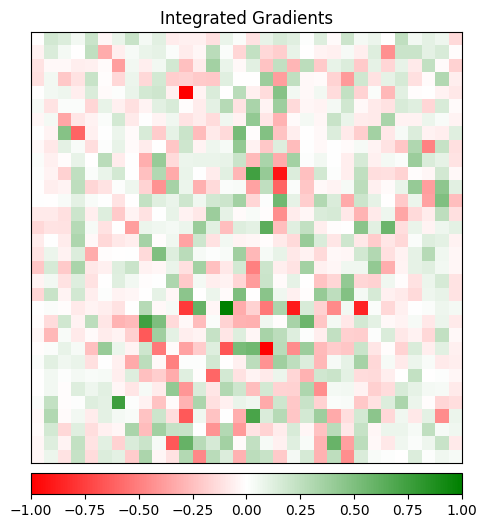

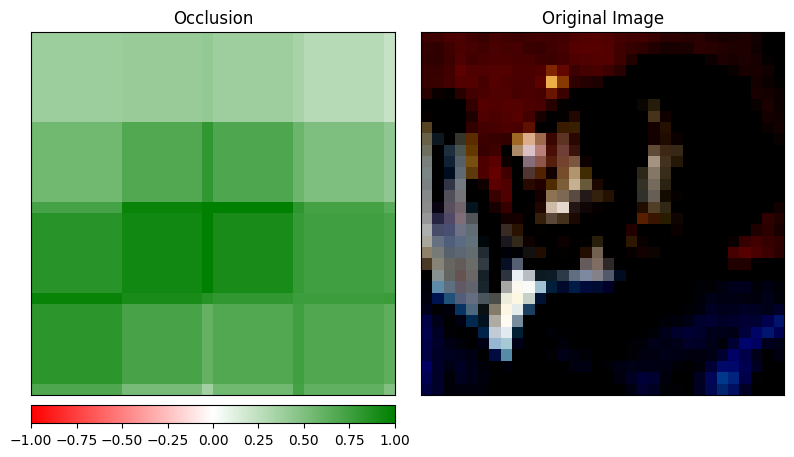

(<Figure size 800x600 with 4 Axes>,
 [<Axes: title={'center': 'Occlusion'}>,
  <Axes: title={'center': 'Original Image'}>])

In [15]:
from captum.attr import (
    GradientShap,
    DeepLift,
    IntegratedGradients,
    Occlusion,
    NoiseTunnel,
    Saliency,
)

from captum.attr import visualization as viz
# Select a single image from the test set for visualization
test_iter = iter(test_loader)
input, target = next(test_iter)
input = input[0].unsqueeze(0).to(device)
target = target[0].to(device)

# Initialize the IntegratedGradients method
ig = IntegratedGradients(model)

# Compute attributions
input.requires_grad_()  # Ensure gradients are computed
attr_ig, delta = ig.attribute(input, target=target, baselines=input * 0, return_convergence_delta=True)

# Visualize the attributions
viz.visualize_image_attr(attr_ig[0].cpu().permute(1, 2, 0).detach().numpy(),
                          input[0].cpu().permute(1, 2, 0).detach().numpy(),
                          method="heat_map",
                          sign="all",
                          show_colorbar=True,
                          title="Integrated Gradients")

occlusion = Occlusion(model)

attr_occ = occlusion.attribute(input,
                                 strides=(3, 8, 8),
                                 target=target,
                                 sliding_window_shapes=(3,15, 15),
                                 baselines=0)

viz.visualize_image_attr_multiple(attr_occ[0].cpu().permute(1, 2, 0).detach().numpy(),
                                  input[0].cpu().permute(1, 2, 0).detach().numpy(),
                                  methods=["heat_map", "original_image"],
                                  signs=["all", "all"],
                                  show_colorbar=True,
                                  titles=["Occlusion", "Original Image"])

In [16]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=88b25203815fa8965d01bf55d5904898268fdd018123eb4305531bc4853cce5a
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/1000 [00:00<?, ?it/s]

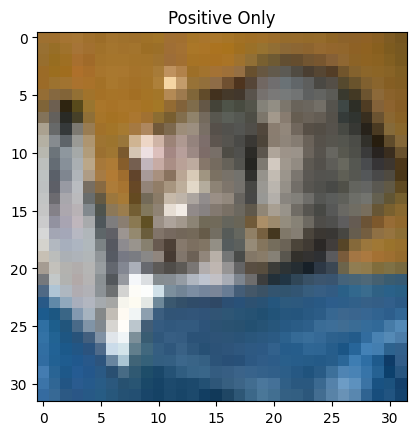

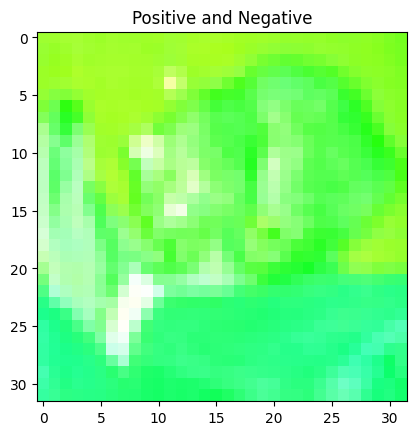

In [19]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

# Choose an image and its target label
test_iter = iter(test_loader)  # Get an iterator from the test loader
images, labels = next(test_iter)  # Get the next batch of images and labels
image, target = images[0], labels[0]  # Select the first image and label
image = image.to(device)  # Move the image to the appropriate device (GPU or CPU)
target = target.item()

# Define a function to predict probabilities for LIME
def predict_fn(images):
    model.eval()
    with torch.no_grad():
        # Convert NumPy arrays to PyTorch tensors and move to device
        # Reshape images to (N, 3, 32, 32) before converting to tensors
        images = [np.transpose(img, (2, 0, 1)) for img in images] #Change:  Reshape to the correct order of dimensions
        images = [torch.tensor(img, dtype=torch.float32, device=device) for img in images]
        images = torch.stack(images)
        logits = model(images)
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    return probs

# Generate explanation
explanation = explainer.explain_instance(image.cpu().permute(1, 2, 0).numpy(),
                                         predict_fn,
                                         top_labels=5,
                                         hide_color=0,
                                         num_samples=1000)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('Positive Only')
plt.show()

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('Positive and Negative')
plt.show()

In [21]:
from PIL import Image

# Replace 'path/to/your/image.jpg' with the actual path to your image file
image_path = '/content/dog.jpeg'

try:
    image = Image.open(image_path)

    # Resize and transform the image
    preprocess = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize to CIFAR-10 input size
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    input_image = preprocess(image).unsqueeze(0).to(device)

except FileNotFoundError:
    print(f"Error: Image file not found at '{image_path}'")
except Exception as e:
    print(f"An error occurred: {e}")

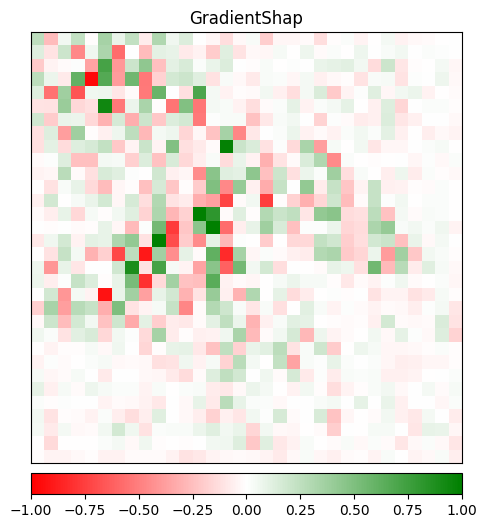

(<Figure size 600x600 with 2 Axes>, <Axes: title={'center': 'GradientShap'}>)

In [22]:
from captum.attr import GradientShap

# Initialize GradientShap
gs = GradientShap(model)

# Compute attributions
input_image.requires_grad_()
attr_gs = gs.attribute(input_image, target=torch.tensor([3]).to(device), baselines=input_image * 0)  # Assuming target class 3 (cat)

# Visualize attributions
viz.visualize_image_attr(attr_gs[0].cpu().permute(1, 2, 0).detach().numpy(),
                          input_image[0].cpu().permute(1, 2, 0).detach().numpy(),
                          method="heat_map",
                          sign="all",
                          show_colorbar=True,
                          title="GradientShap")

  0%|          | 0/1000 [00:00<?, ?it/s]

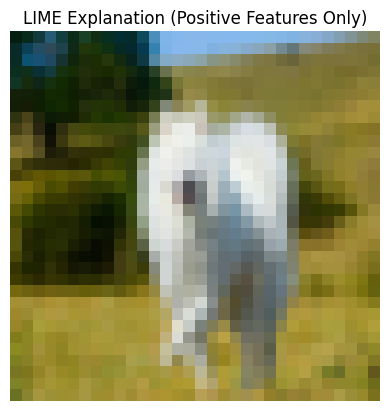

In [28]:
# Predict function for LIME
def predict_fn(images):
    model.eval()
    with torch.no_grad():
        # Reshape images to (N, 3, 96, 96)
        images = [np.transpose(img, (2, 0, 1)) for img in images]
        images = [torch.tensor(img, dtype=torch.float32, device=device) for img in images]
        images = torch.stack(images, dim=0)
        logits = model(images)
        probs = torch.nn.functional.softmax(logits, dim=1).cpu().numpy()
    return probs

# Generate LIME explanation (fully fixed)
explanation = explainer.explain_instance(
    input_image.squeeze(0).detach().cpu().permute(1, 2, 0).numpy(),
    predict_fn,
    top_labels=5,
    hide_color=0,
    num_samples=1000
)

# Visualize LIME explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=True
)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title('LIME Explanation (Positive Features Only)')
plt.axis('off')
plt.show()



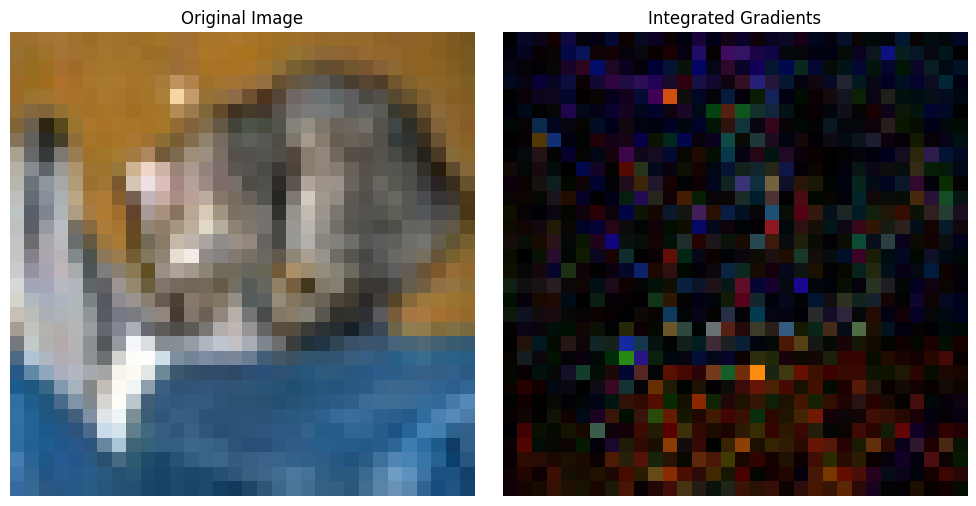

In [33]:
# Unnormalize image before plotting
def unnormalize(tensor):
    return tensor * 0.5 + 0.5  # since you used Normalize((0.5,), (0.5,))

unnorm_image = unnormalize(input_image.squeeze().cpu()).numpy()
axs[0].imshow(np.transpose(unnorm_image, (1, 2, 0)))


import torch
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np

# Pick one image from the test set
image, label = next(iter(test_loader))
input_image = image[0].unsqueeze(0).to(device)  # shape: [1, 3, 96, 96] for STL10
target_label = label[0].item()

# Initialize Captum's Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions
attributions, _ = ig.attribute(input_image, target=target_label, return_convergence_delta=True)

# Convert to numpy for plotting
attributions = attributions.squeeze().cpu().detach().numpy()
input_image_np = input_image.squeeze().cpu().detach().numpy()

# Normalize and plot
def normalize(arr):
    arr = np.abs(arr)
    arr -= arr.min()
    arr /= arr.max() + 1e-8
    return arr

# Plot original image and attributions
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Original image (unnormalized)
unnorm_image = unnormalize(input_image.squeeze().cpu()).numpy()
axs[0].imshow(np.transpose(unnorm_image, (1, 2, 0)))
axs[0].set_title("Original Image")
axs[0].axis("off")


# Attribution map
axs[1].imshow(np.transpose(normalize(attributions), (1, 2, 0)), cmap="hot")
axs[1].set_title("Integrated Gradients")
axs[1].axis("off")

plt.tight_layout()
plt.show()


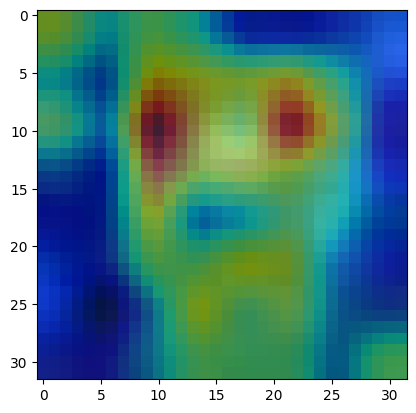

In [34]:
import cv2
import numpy as np
import torch.nn.functional as F
from torchvision import transforms

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        # Register hook to save gradients
        self.model.eval()  # Set the model to evaluation mode

        for name, module in self.model.model._modules.items():  # Assuming your model has a submodule named 'model'
            x = module(x)
            if name == self.target_layer:  # or if name is your target layer
                x.register_hook(self.save_gradient)
                output = x  # Save the output of the target layer

        x = self.model.model._modules['10'](output) # Assuming the next layer after the target layer has index 11
        x = self.model.model._modules['11'](x)

        return x

    def __call__(self, x, index=None):

        output = self.forward(x)

        if index is None:
            index = output.argmax(dim=1)

        one_hot = torch.zeros_like(output)
        one_hot[:, index] = 1

        output.backward(gradient=one_hot, retain_graph=True)

        gradients = self.gradients.data.cpu().numpy()[0]
        weights = np.mean(gradients, axis=(1, 2))

        activation_map = output.data.cpu().numpy()[0]
        cam = np.zeros(activation_map.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activation_map[i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (32, 32))  # Resize to input image dimensions
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

# Create GradCAM object
target_layer = '8' # Specify the name or index of your target layer here
gradcam = GradCAM(model=model, target_layer=target_layer)

# Load your sample image
image_path = '/content/dog.jpeg'
image = Image.open(image_path)

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize to CIFAR-10 input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
input_image = preprocess(image).unsqueeze(0).to(device)

# Generate Grad-CAM heatmap
heatmap = gradcam(input_image)

# Display the heatmap (you'll need to add visualization code here)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.imshow(image)
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap on original image
plt.show()

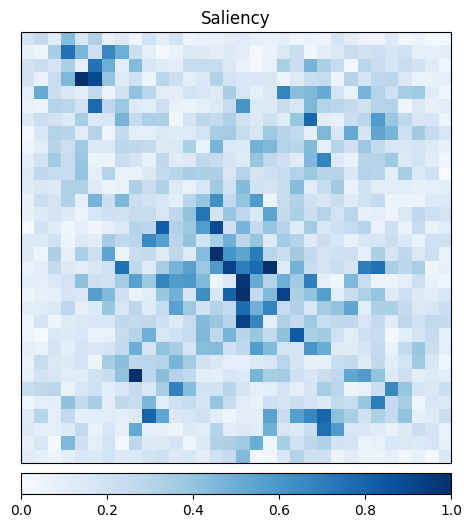

(<Figure size 600x600 with 2 Axes>, <Axes: title={'center': 'Saliency'}>)

In [35]:
from captum.attr import Saliency
from captum.attr import visualization as viz

# Initialize Saliency
saliency = Saliency(model)

# Compute attributions
input_image.requires_grad_()
attr_saliency = saliency.attribute(input_image, target=torch.tensor([3]).to(device)) # Assuming target class 3

# Visualize attributions
viz.visualize_image_attr(attr_saliency[0].cpu().permute(1, 2, 0).detach().numpy(),
                          input_image[0].cpu().permute(1, 2, 0).detach().numpy(),
                          method="heat_map",
                          sign="absolute_value", # or "all" to show both positive and negative
                          show_colorbar=True,
                          title="Saliency")

/usr/local/lib/python3.11/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:66: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


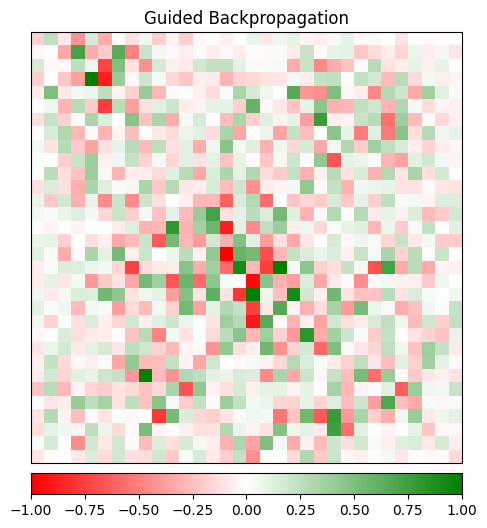

(<Figure size 600x600 with 2 Axes>,
 <Axes: title={'center': 'Guided Backpropagation'}>)

In [37]:
from captum.attr import GuidedBackprop

# Initialize Guided Backpropagation
gbp = GuidedBackprop(model)

# Compute attributions
input_image.requires_grad_()
attr_gbp = gbp.attribute(input_image, target=torch.tensor([3]).to(device)) # Assuming target class 3

# Visualize attributions
viz.visualize_image_attr(attr_gbp[0].cpu().permute(1, 2, 0).detach().numpy(),
                          input_image[0].cpu().permute(1, 2, 0).detach().numpy(),
                          method="heat_map",
                          sign="all", # or "positive" to show only positive influences
                          show_colorbar=True,
                          title="Guided Backpropagation")